# TCN Classifier

In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import sys
import numpy as np
import datetime

from sklearn.metrics import accuracy_score

sys.path.append('../scripts')
import ml_helper
import ml_evaluation

Code inspiered:

https://de.mathworks.com/help/deeplearning/ug/sequence-to-sequence-classification-using-1-d-convolutions.html

References:

- [1] Bai, Shaojie, J. Zico Kolter, and Vladlen Koltun. “An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling.” Preprint, submitted April 19, 2018. https://arxiv.org/abs/1803.01271.

- [2] Oord, Aaron van den, Sander Dieleman, Heiga Zen, Karen Simonyan, Oriol Vinyals, Alex Graves, Nal Kalchbrenner, Andrew Senior, and Koray Kavukcuoglu. “WaveNet: A Generative Model for Raw Audio.” Preprint, submitted September 12, 2016. https://arxiv.org/abs/1609.03499.

- [3] Tompson, Jonathan, Ross Goroshin, Arjun Jain, Yann LeCun, and Christoph Bregler. “Efficient Object Localization Using Convolutional Networks.” 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 648–56. https://doi.org/10.1109/CVPR.2015.7298664.


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Creating the Network

In [3]:
class TemporalConvNet(nn.Module):
    def __init__(self, num_features: int, num_classes: int, num_filters: int, filter_size: int, 
                 dropout_factor: float, num_blocks: int, parallel_layer: bool) -> None:
        """
        This function initializes the TemporalConvNet model
        ------
        num_features: number of features in the input
        num_classes: number of classes to predict
        num_filters: number of filters in each convolutional layer
        filter_size: size of the convolutional filter
        dropout_factor: dropout factor
        num_blocks: number of blocks of dilated convolutions
        parallel_layer: whether to add the parallel layer
        """
        super(TemporalConvNet, self).__init__()
        self.num_blocks = num_blocks
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.dropout_factor = dropout_factor
        self.parallel_layer = parallel_layer
        if self.parallel_layer:
            self.optional_layer = nn.Conv1d(num_features, num_filters, kernel_size=1)

        self.layers = nn.ModuleList()
        # Input layer
        self.layers.append(nn.Conv1d(num_features, num_filters, kernel_size=1))
        self.layers.append(nn.BatchNorm1d(num_filters))
        
        # Dilated convolutional blocks
        for i in range(num_blocks):
            dilation = 2 ** i
            # this function defines the padding and therefore teh sequence length
            pad = (filter_size - 1) * dilation // 2 
            # TODO: fix for even filter size
            self.layers.append(nn.Conv1d(num_filters, num_filters, kernel_size=filter_size, dilation=dilation, padding=pad))
            self.layers.append(nn.BatchNorm1d(num_filters))
            # if last than not dropout
            if i != num_blocks - 1:
                self.layers.append(nn.Dropout(dropout_factor))

        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout_factor))

        self.layers.append(nn.Softmax(dim=1))

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        This function defines the forward pass of the model
        ------
        x: input tensor of shape (batch_size, num_features, sequence_length)
        ------
        returns: output tensor of shape (batch_size, num_classes, sequence_length)
        """
        x_init = x.permute(0, 2, 1)
        x = x_init.clone()
        for layer in self.layers:
            x = layer(x)
        # skipped all other connections and add it at the end
        if self.parallel_layer:
            x_optional = self.optional_layer(x_init)
            x = x + x_optional

        return x

In [4]:
def train(model, data: DataLoader, epochs: int, optimizer: optim.Optimizer, loss_fn: nn.Module) -> None:
    """
    Trains the model for the specified number of epochs
    ------
    model: TCN model
    data: DataLoader with the training data
    epochs: number of epochs to train the model
    optimizer: optimizer to use
    loss_fn: loss function to use
    ------
    Returns the training losses and accuracies
    """
    trainings_losses = []
    trainings_accuracies = []

    model.to(device)
    model.train()

    for epoch in range(epochs):
        accuracies = []
        losses = []
        for inputs, labels in data:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_fn(outputs.squeeze(), labels.squeeze().long())
            loss.backward()
            optimizer.step()
            
            # get accuracy
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.view(-1)
            labels = labels.view(-1)
            acc = accuracy_score(labels.cpu(), predicted.cpu())
            accuracies.append(acc)

            losses.append(loss.item())
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {round(np.mean(losses), 3)}, accuracy: {round(np.mean(accuracies), 3)}')
        trainings_losses.append(np.mean(losses))
        trainings_accuracies.append(np.mean(accuracies))
    return trainings_losses, trainings_accuracies

### Data Preparation

In [5]:
# Data preparation
organism = "E.Coli"
#"Homo.Sapiens"  "Drosophila.Melanogaster"  "E.Coli"
min_length = 100
max_length = 500
BATCH_SIZE = 32

train_dataset = ml_helper.CodonDataset(organism, "train", min_length, max_length, one_hot_aa=True)
print(f"Länge train_dataset: {len(train_dataset)}")
test_dataset = ml_helper.CodonDataset(organism, "test", min_length, max_length, one_hot_aa=True)
print(f"Länge test_dataset: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

Länge train_dataset: 2284
Länge test_dataset: 592


### Hyperparameters and Model Initialization

In [6]:
# Hyperparameters
num_features = len(ml_helper.amino_acids)
num_classes = len(ml_helper.codons)  # number of codons (output classes)
num_filters = 128 #64
filter_size = 5#3  # NOTE: filter size must be unequal like: 3,5,9,...
dropout_factor = 0.008 #0.005
num_blocks = 5#2
parallel_layer = True

# Model
tcnModel = TemporalConvNet(num_features, num_classes, num_filters, filter_size, 
                        dropout_factor, num_blocks, parallel_layer)
print(tcnModel)

# Train variables
NUM_EPOCHS = 100
learing_rate = 0.001 # 0.001
criterion = nn.CrossEntropyLoss(ignore_index=64)
optimizer = optim.Adam(tcnModel.parameters(), lr=learing_rate)

TemporalConvNet(
  (optional_layer): Conv1d(22, 128, kernel_size=(1,), stride=(1,))
  (layers): ModuleList(
    (0): Conv1d(22, 128, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.008, inplace=False)
    (5): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(4,), dilation=(2,))
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.008, inplace=False)
    (8): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(8,), dilation=(4,))
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.008, inplace=False)
    (11): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(16,), dilation=(8,))
    (12): BatchNorm1d

### Start Training

In [7]:
#trainings_losses, trainings_accuracies = train(tcnModel, train_loader, NUM_EPOCHS, optimizer, criterion)

### Save the model

In [8]:
model_name = "tcn"

def safe_model(model, name_model, organism=organism):
    # timestamp
    now = datetime.datetime.now()
    timestamp = now.strftime("%Y%m%d%H%M%S")

    # save model in ml_models in a single file
    torch.save(model, f"../ml_models/{name_model}_{organism}_model_{timestamp}.pt")
    print(f"Model saved as tcn_{organism}_model_{timestamp}.pt")

# save model
#safe_model(tcnModel, model_name)

### Load the model

In [11]:
import os
# get the newest version of the tcn model
tcnModels = os.listdir("../ml_models")
# get only tcn models
tcnModels = [model_name for model_name in tcnModels if model_name in model_name and organism in model_name]
# sort by date
tcnModels.sort()
# get newest model
tcnModel_name = tcnModels[-1]
# load model
tcnModel = torch.load(f"../ml_models/{organism}/tcn_E.Coli_model_20240511141307.pt")
print(f"Model loaded: {tcnModel_name}")

Model loaded: E.Coli


### Evaluation of the model

In [12]:
predicted, labels, accuracies = ml_evaluation.evaluate_model(tcnModel, device, test_loader)

#### Get codon names and associated amino acids

In [13]:
predicted = predicted.cpu().numpy()
labels = labels.cpu().numpy()

predicted, labels = ml_evaluation.filter_padding(predicted, labels, filter_value=64)

predicted_codon_names =  ml_evaluation.codon_to_name(predicted)
labels_codon_names =  ml_evaluation.codon_to_name(labels)

predicted_aa =  ml_evaluation.translate_codons(predicted_codon_names)
labels_aa =  ml_evaluation.translate_codons(labels_codon_names)

ml_evaluation.get_unique_pred_classes(predicted_codon_names, labels_codon_names)
ml_evaluation.print_unique_elements(predicted_aa, labels_aa)

predicted different classes:  51 out of: 64
predicted following classes:  {'CTG', 'CAA', 'ATG', 'AGC', 'TGG', 'TTC', 'GGT', 'GCT', 'GTC', 'TGT', 'ACT', 'TCA', 'GTT', 'GGG', 'CGT', 'GGC', 'GCC', 'AGT', 'ATC', 'GAA', 'TGC', 'AAT', 'CAC', 'GCA', 'GTA', 'TAC', 'GCG', 'TAA', 'TCC', 'AAA', 'CAG', 'GTG', 'GAG', 'TTT', 'CCG', 'ACG', 'GAT', 'CGC', 'GAC', 'TCT', 'CCT', 'AAC', 'ACC', 'ACA', 'TGA', 'ATT', 'CAT', 'TAT', 'CCA', 'TCG', 'AAG'}
predicted different amino acids:  21 out of: 21


#### Accuracies

In [14]:
# Calculate Accuracy of amino 
avg_accuracy = np.mean(accuracies)
accuracy_aa = accuracy_score(labels_aa, predicted_aa)

print('-' * 100)
print(f'Average accuracy: {avg_accuracy}')
print(f'Accuracy of amino acids: {accuracy_aa}')
print('-' * 100)

----------------------------------------------------------------------------------------------------
Average accuracy: 0.2957533783783784
Accuracy of amino acids: 1.0
----------------------------------------------------------------------------------------------------


## Plots

In [15]:
# check if training losses and accuracies is defined
if 'trainings_losses' in locals() and 'trainings_accuracies' in locals():
    # plot of training loss and accuracy
    plt = ml_evaluation.plot_training(trainings_losses, trainings_accuracies)
    plt.show()
else:
    print("No training losses and accuracies available")

No training losses and accuracies available


### Codon Accuracy

$$C\_Acc = \frac{T\_c}{G\_c} $$

- $T\_c$: Anzahl des richtig klassifizierten ausgewählten Codons über alle Testsequenzen eines betrachteten Organismus
- $G\_c$: Gesamtanzahl des ausgewählten Codons über alle Testsequenzen eines betrachteten Organismus

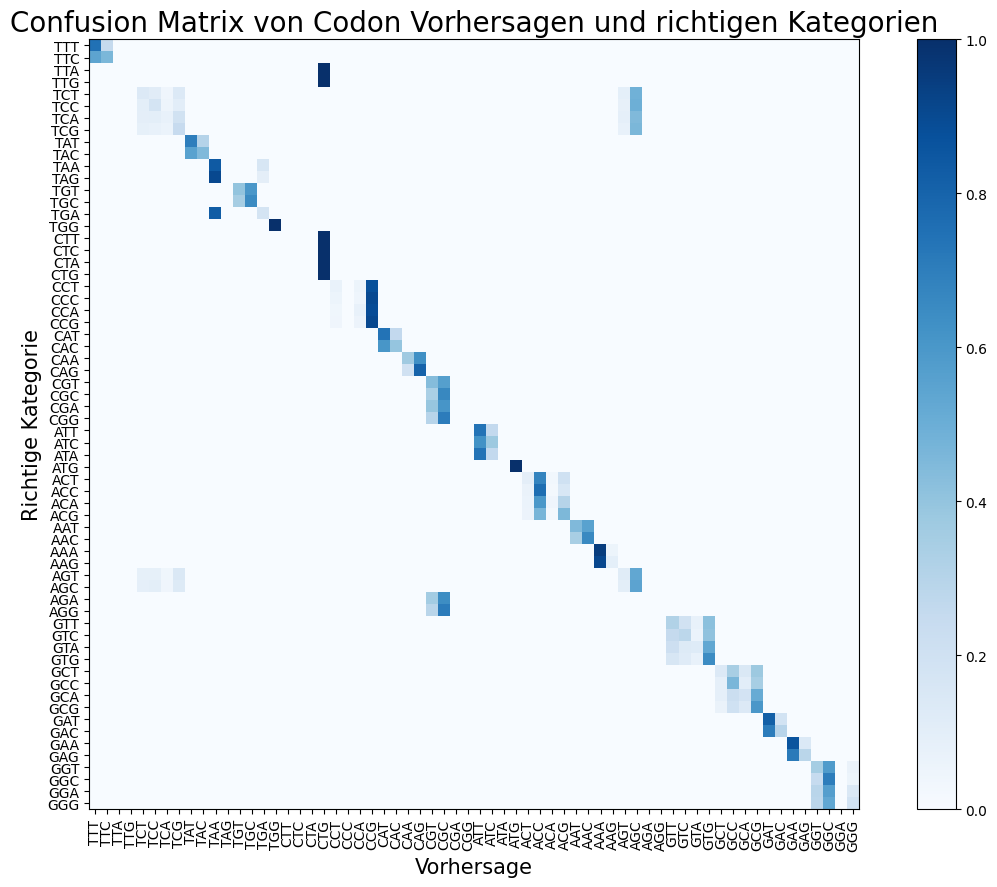

In [16]:
title = 'Confusion Matrix von Codon Vorhersagen und richtigen Kategorien'

codons = [c for c in ml_helper.codons if c != '___']

plt = ml_evaluation.plot_confusion_matrix(labels, predicted, codons, title)
plt.show()
#plt = ml_evaluation.plot_confusion_matrix_sns(labels, predicted, codons, title)
#plt.show()

### Aminosäuren Accuracy

$$A\_Acc = \frac{T\_a}{G\_a} $$

- $T\_a$: Anzahl der richtig klassifizierten ausgewählten Aminosäure über alle Testsequenzen eines betrachteten Organismus
- $G\_a$: Gesamtanzahl der ausgewählten Aminosäure über alle Testsequenzen eines betrachteten Organismus

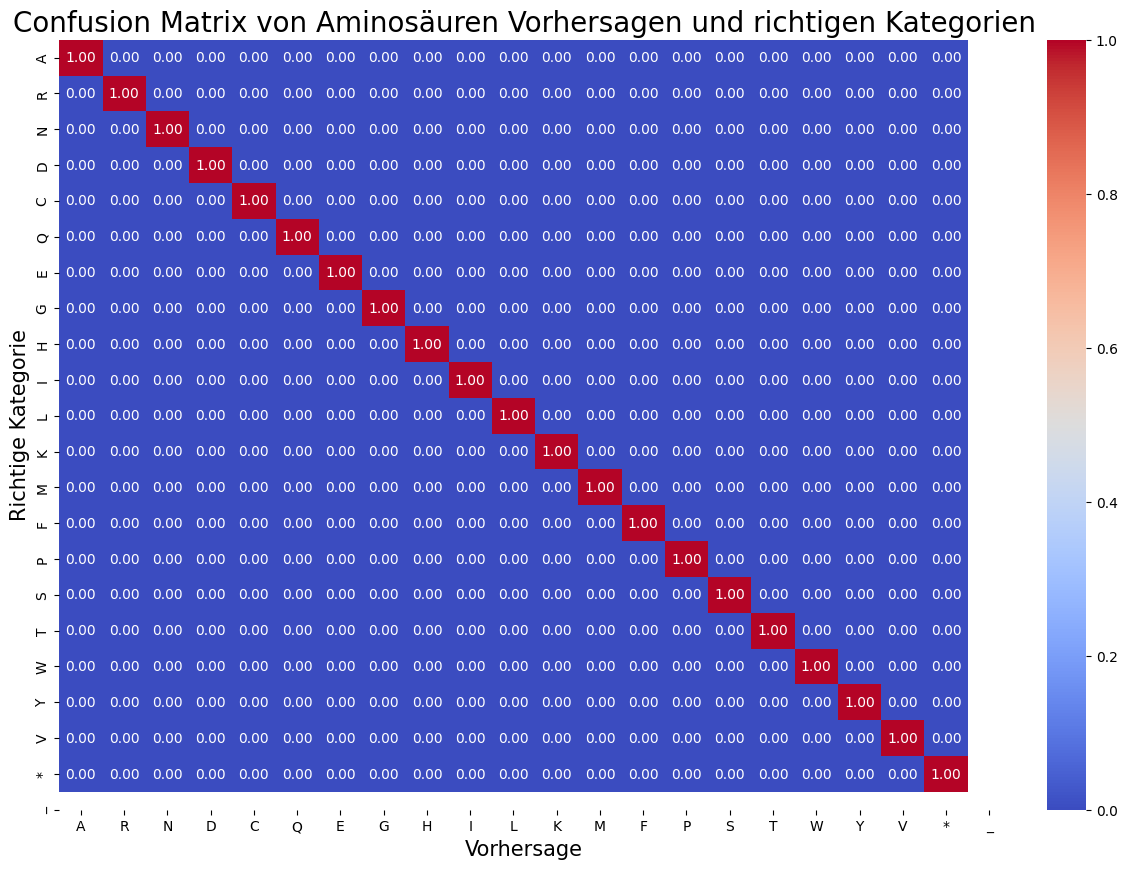

In [17]:
# Calculate confusion matrix for amino acids

plt = ml_evaluation.plot_confusion_matrix_sns(labels_aa, predicted_aa, ml_helper.amino_acids, 
                                        'Confusion Matrix von Aminosäuren Vorhersagen und richtigen Kategorien')
plt.show()

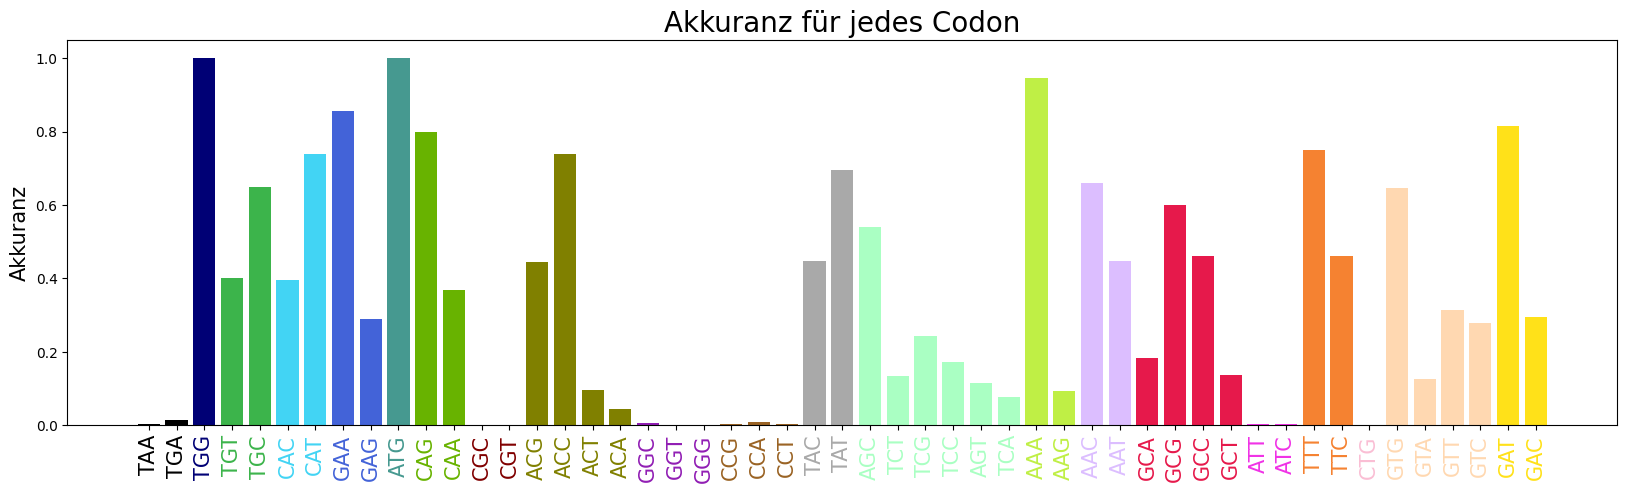

In [18]:
plt = ml_evaluation.plot_codon_acc(labels, predicted, 'Akkuranz für jedes Codon')


(35, 19, 32, 19, 33, 45, 23, 54, 42, 39, 19, 56, 9, 27, 6, 23, 19, 37, 37, 39, 29, 8, 37, 19, 20, 58, 19, 19, 56, 41, 45, 27, 26, 19, 32, 25, 58, 55, 28, 42, 19, 39, 22, 23, 26, 33, 5, 39, 19, 35, 29, 32, 45, 56, 42, 19, 55, 61, 32, 40, 53, 55, 28, 0, 24, 57, 15, 27, 23, 56, 1, 37, 22, 52, 40, 53, 29, 27, 55, 32, 19, 55, 0, 42, 61, 56, 51, 8, 37, 61, 19, 27, 55, 58, 37, 1, 45, 58, 56, 56, 1, 57, 0, 53, 27, 27, 24, 19, 29, 35, 19, 4, 60, 19, 8, 61, 51, 19, 28, 23, 19, 56, 19, 35, 27, 20, 9, 28, 19, 58, 35, 61, 32, 28, 19, 58, 41, 53, 28, 61, 42, 56, 19, 8, 27, 1, 15, 61, 56, 32, 33, 37, 41, 42, 19, 41, 58, 55, 19, 52, 52, 27, 61, 56, 41, 51, 51, 33, 40, 19, 52, 45, 56, 58, 8, 1, 42, 7, 50, 43, 23, 42, 43, 19, 40, 52, 58, 33, 33, 42, 23, 48, 1, 19, 56, 58, 42, 41, 61, 43, 1, 42, 32, 33, 4, 1, 9, 55, 42, 42, 55, 29, 61, 19, 35, 45, 28, 1, 32, 32, 58, 41, 29, 19, 37, 42, 23, 58, 27, 19, 36, 61, 0, 41, 45, 58, 60, 9, 1, 1, 56, 58, 57, 5, 6, 45, 40, 60, 58, 19, 50, 0, 43, 28, 8, 58, 27, 28, 

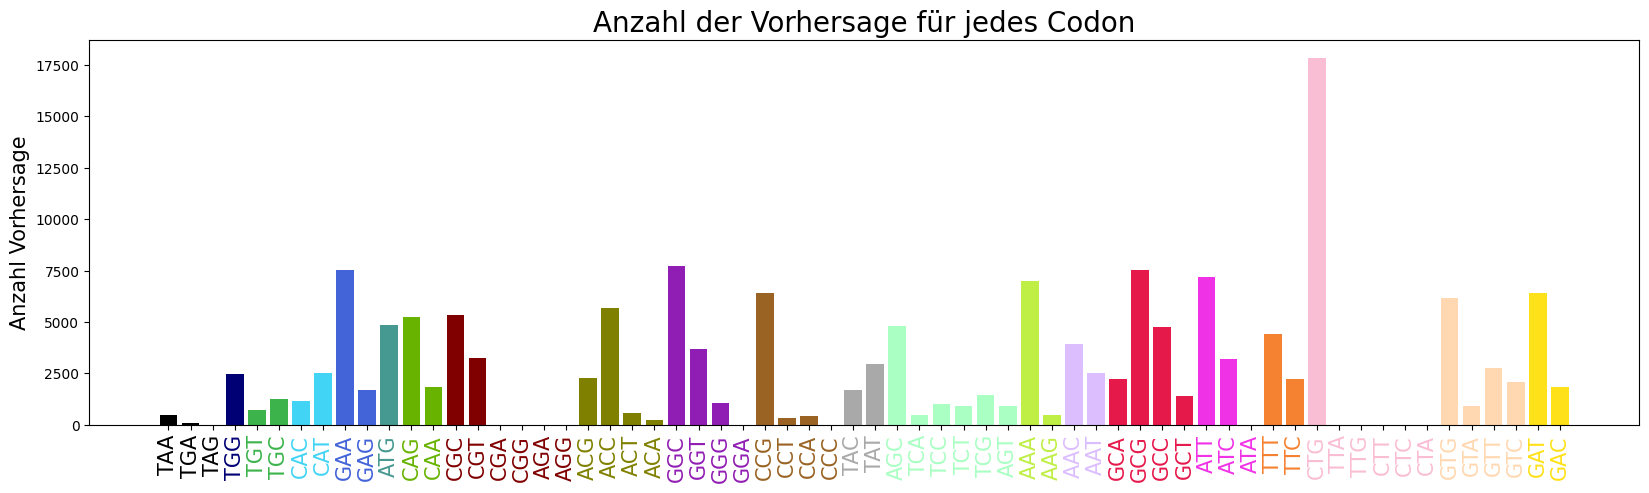

In [ ]:
codon_counted_predicted = ml_evaluation.codon_count(predicted)

plt = ml_evaluation.plot_codon_count(codon_counted_predicted, 'Anzahl der Vorhersage für jedes Codon')

### Durchschnittliche Codon Accuracy

$$Avg\_CACC = \frac{\sum_{sc \in SC} c\_acc\{sc\}}{|SC|} $$

- $c\_acc$: Codon Accuracy
- $SC$: Synonyme Codons für die ausgewählte Aminosäure über alle Testsequenzen eines betrachteten Organismus

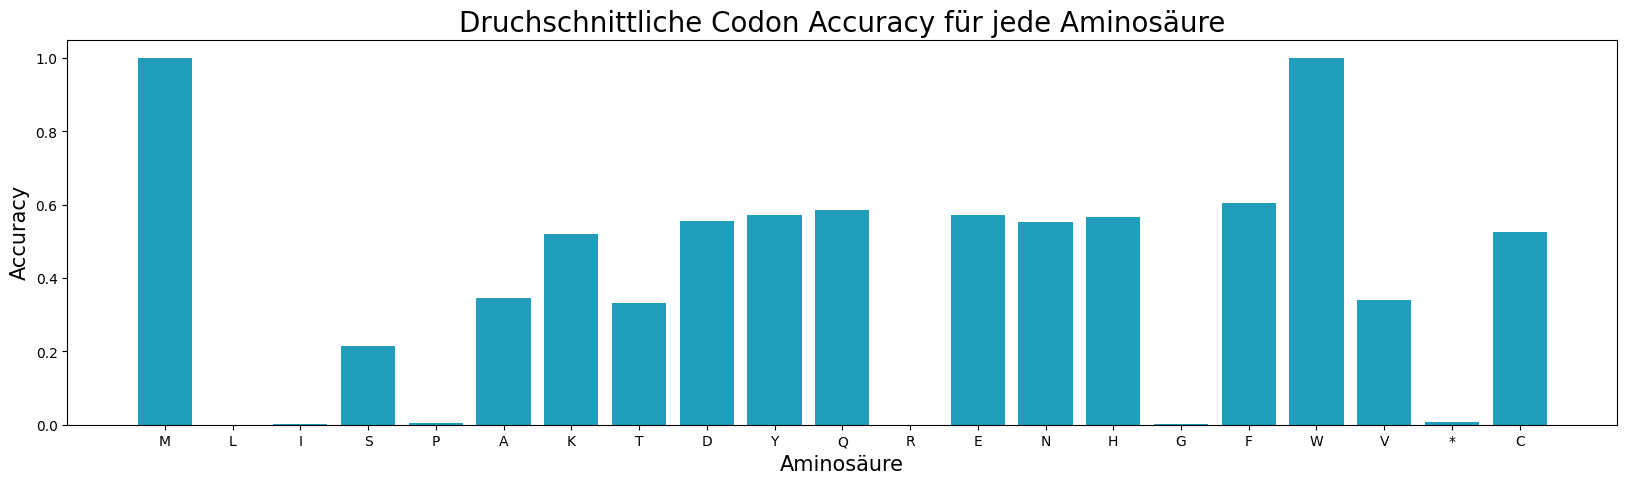

In [ ]:

plt = ml_evaluation.plot_avg_aa_acc(labels, predicted)
plt.show()

In [37]:
import Classifier as Classifier

class TCNNClassifier(Classifier.Classifier):
    def __init__(self, trained_model, seed=42):
        self.model = trained_model
        super().__init__(seed)


    def predict_codons(self, aa_sequences, replace=False):
        # aa to tensor
        aa_sequences.apply(ml_helper.aa_int_to_onehot_tensor)
        #aa_sequences = torch.tensor(aa_sequences)
        print(aa_sequences.shape)
        aa_sequences = ml_helper.aa_int_to_onehot_tensor(aa_sequences)
        print(aa_sequences.shape)
        outputs = self.model(aa_sequences)
        
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.view(-1)
        predicted = predicted.cpu().numpy()
        return predicted


In [38]:
import pandas as pd
organism = "E.Coli"

def group_codons(sequence):
    return [''.join(sequence[i:i+3]) for i in range(0, len(sequence), 3)]

df = pd.read_pickle(f"../data/{organism}/cleanedData_test.pkl")
#usage_biases = pd.read_pickle(f"../data/{organism}/usageBias.pkl")
#df['codons'] = df['sequence'].apply(group_codons)

In [39]:
#%%time 
tcnn_classifier = TCNNClassifier(tcnModel)
pred_codons = {}
amino_seq = df['translation']
# amino seq to list
#true_codons = df['codons']
#pred_codons = encoder_classifier.predict_codons(amino_seq)
pred_codons_replaced = tcnn_classifier.predict_codons(amino_seq, replace=True)

AttributeError: 'SeqRecord' object has no attribute 'long'

In [ ]:
#error_rate = encoder_classifier.calc_error_rate(true_codons, pred_codons)
error_rate_replaced = tcnn_classifier.calc_error_rate(true_codons, pred_codons_replaced)
#print(f"Organismus {organism} - Error Rate: {error_rate}")
print(f"Organismus {organism} - Error Rate with replaced codons: {error_rate_replaced}")

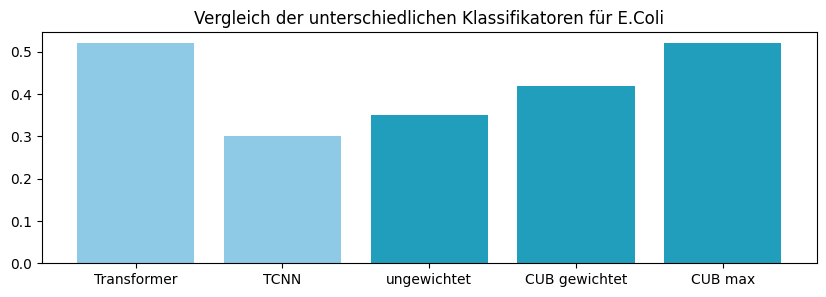

In [ ]:
# Accuracy for basilines unweighted, weighted, max, tcnn validation, tcnn training
accuracies = [0.52, 0.30, 0.35, 0.42, 0.52]
labels = ['Transformer', 'TCNN', 'ungewichtet', 'CUB gewichtet', 'CUB max']

import matplotlib.pyplot as plt
# Define colors for each group
colors = ['#8ecae6', '#8ecae6', '#219ebc', '#219ebc', '#219ebc']

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(labels, accuracies, color=colors)
plt.title('Vergleich der unterschiedlichen Klassifikatoren für E.Coli')
plt.show()
